In [1]:
import numpy as np
import pandas as pd
import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns

from functools import partial
from numba import njit

plt.rcParams["figure.figsize"] = (14, 8)
sns.set_style("whitegrid")

## Problem 6.1

In [2]:
def draw_normal(size, theta, seed=0):
    np.random.seed(seed)
    sample = np.random.normal(theta, scale=1, size=size)
    return sample

In [3]:
def critical_value(alpha):
    quantile = scipy.stats.norm.ppf(1 - alpha)
    return quantile

In [4]:
def power_func(theta, alpha, sample_size, theta_0):
    upper_bound = np.sqrt(sample_size) * (theta_0 - theta) - critical_value(alpha)
    power = scipy.stats.norm.cdf(upper_bound)
    return power

### Theoretical Power Function:

In [5]:
powerf = partial(power_func, alpha=0.05, sample_size=100, theta_0=1)

theta_grid = np.linspace(0.5, 1.2, num=1_000)
power = powerf(theta_grid)

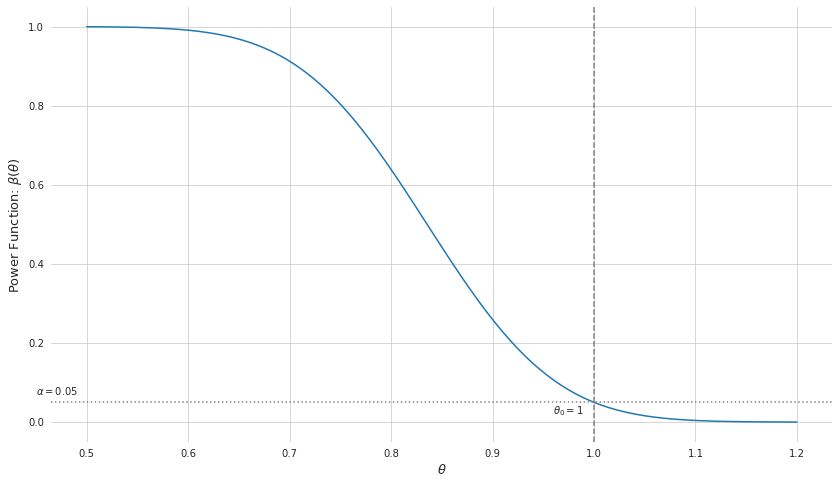

In [6]:
fig, ax = plt.subplots(1)

sns.lineplot(x=theta_grid, y=power, ax=ax)

ax.axvline(1, ls="--", color="grey")
ax.text(0.96, 0.02, r"$\theta_0 = 1$")
ax.axhline(0.05, ls=":", color="grey")
ax.text(0.45, 0.07, r"$\alpha=0.05$")

ax.set(ylabel=r"Power Function: $\beta(\theta)$", xlabel=r"$\theta$")
ax.set_frame_on(False)
ax.xaxis.label.set_size(13)
ax.yaxis.label.set_size(13)

In [7]:
def confidence_interval(sample, alpha):
    best_guess = sample.mean()
    crit_value = critical_value(alpha)
    interval = pd.Interval(-np.inf, best_guess + (crit_value / np.sqrt(len(sample))))
    return interval

### Example:

In [8]:
theta = 1.5

sample = draw_normal(size=1_000, theta=theta, seed=1)
ci = confidence_interval(sample, alpha=0.05)
print(f"Confidence Interval: {ci}\n->Theta in CI.\n")

sample = draw_normal(size=1_000, theta=theta, seed=14)
ci = confidence_interval(sample, alpha=0.05)
print(f"Confidence Interval: {ci}\n->Theta not in CI.")

Confidence Interval: (-inf, 1.5908273149471575]
->Theta in CI.

Confidence Interval: (-inf, 1.4639735291422886]
->Theta not in CI.


## Problem 6.2

In [9]:
def moment_of_exponential(n, theta):
    return np.math.factorial(n) * (theta ** n)

In [10]:
def critical_value(alpha):
    quantile = scipy.stats.norm.ppf(1 - alpha / 2)
    return quantile

In [11]:
def draw_exponential(size, theta, seed=0):
    np.random.seed(seed)
    sample = np.random.exponential(scale=theta, size=size)
    return sample

In [12]:
def theta_hat(sample):
    estimate = np.mean(sample, axis=0)
    return estimate

In [13]:
def theta_tilde(sample):
    estimate = np.sqrt(np.mean(sample ** 2, axis=0) / 2)
    return estimate

In [14]:
def standard_error_hat(sample_size, theta):
    variance = theta ** 2
    return np.sqrt(variance / sample_size)

In [15]:
def asymptotic_standard_error_tilde(sample_size, theta):
    variance = (5 / 4) * theta ** 2
    return np.sqrt(variance / sample_size)

In [16]:
def statistic_one(sample, theta_0):
    statistic = (theta_hat(sample) - theta_0) / standard_error_hat(len(sample), theta_0)
    return statistic

In [17]:
def statistic_two(sample, theta_0):
    statistic = (theta_tilde(sample) - theta_0) / asymptotic_standard_error_tilde(
        len(sample), theta_0
    )
    return statistic

In [18]:
def finite_sample_power_func(n_grid_points, theta_0, alpha, sample_size, n_runs):
    crit_value = critical_value(alpha)
    theta_grid = np.linspace(1, 3.5, num=n_grid_points)
    power = np.zeros((n_grid_points, 2))
    for i in range(n_grid_points):
        sample = draw_exponential((sample_size, n_runs), theta_grid[i], seed=i)
        stat_one = statistic_one(sample, theta_0)
        stat_two = statistic_two(sample, theta_0)
        power[i, 0] = (np.abs(stat_one) > crit_value).mean()
        power[i, 1] = (np.abs(stat_two) > crit_value).mean()
    df = pd.DataFrame(np.c_[theta_grid, power], columns=["theta", "hat", "tilde"])
    df = df.melt(id_vars="theta", value_name="power", var_name="estimator_type")
    return df

### Simulated Power Function:

In [19]:
df = finite_sample_power_func(n_grid_points=500, theta_0=2, alpha=0.05, sample_size=100, n_runs=10_000)

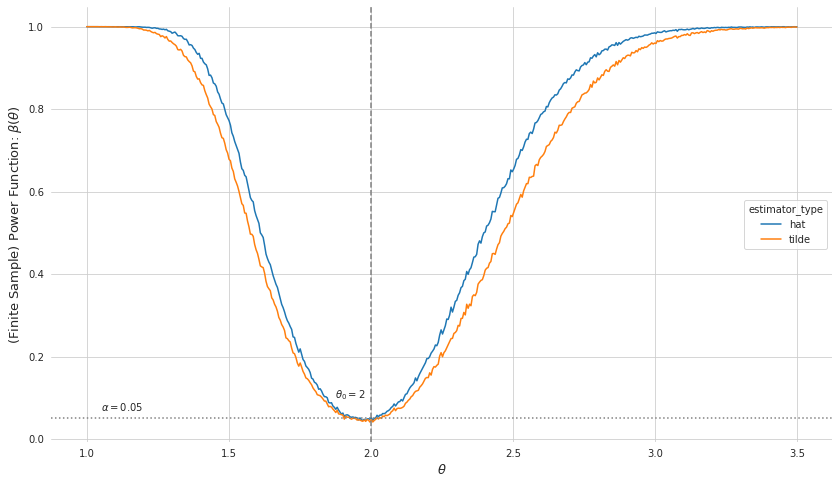

In [20]:
fig, ax = plt.subplots(1)

sns.lineplot(x="theta", y="power", hue="estimator_type", data=df, ax=ax)

ax.axvline(2, ls="--", color="grey")
ax.text(1.875, 0.1, r"$\theta_0 = 2$")
ax.axhline(0.05, ls=":", color="grey")
ax.text(1.05, 0.07, r"$\alpha=0.05$")

ax.set(ylabel=r"(Finite Sample) Power Function: $\beta(\theta)$", xlabel=r"$\theta$")
ax.set_frame_on(False)
ax.xaxis.label.set_size(13)
ax.yaxis.label.set_size(13)

## Problem 6.3

In [21]:
df = pd.read_excel("data/SummerWinterData.xlsx").set_index("Year")

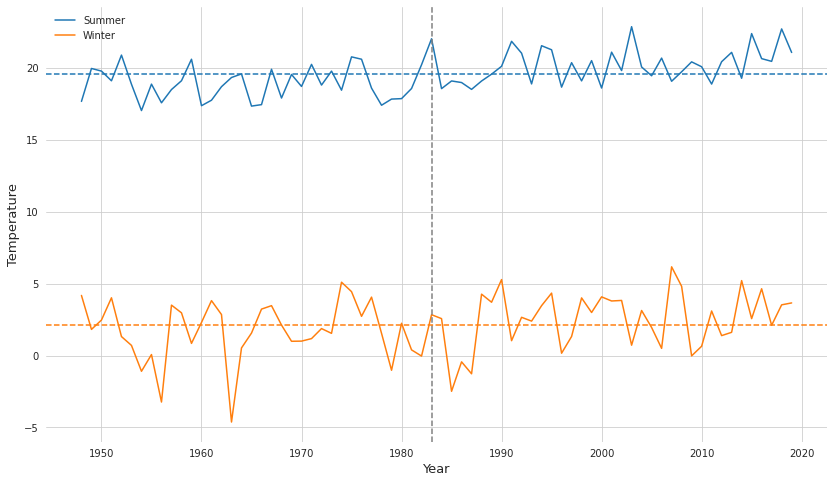

In [41]:
fig, ax = plt.subplots(1)

sns.lineplot(x="Year", y="Temperature", hue="Season", data=df, ax=ax)
ax.axvline(1983, ls="--", color="grey")

means = df.groupby("Season").mean()
ax.axhline(means.loc["Summer"].values, ls="--", color="C0")
ax.axhline(means.loc["Winter"].values, ls="--", color="C1")

ax.set_frame_on(False)
ax.xaxis.label.set_size(13)
ax.yaxis.label.set_size(13)
_ = plt.legend(frameon=False)

In [23]:
df_before = df.query("Year <= 1983")
df_after = df.query("Year > 1983")

In [24]:
df_before.groupby("Season").std()

,Temperature
Season,
Summer,1.223441
Winter,2.055581


In [25]:
df_after.groupby("Season").std()

,Temperature
Season,
Summer,1.197797
Winter,1.966947
